***


# Projet : Reed-Salomon, QR code et correction d’erreur
***
***


Jean-Loup Mellion  
Gatien Da Rocha

In [304]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import itertools

# Rappel interpolation polynomiale

Avant de s'attaquer a Reed-Salomon, il est important de rappeler le principe de l'interpolation polynomiale. L'interpolation polynomiale est une méthode mathématique permettant de trouver un polynôme qui passe par un ensemble de points donnés.

Pour cela, nous allons utiliser la méthode de Lagrange. Cette méthode permet de trouver un polynôme de degré n-1 passant par n points donnés.

### Polynôme de Lagrange

In [305]:
def polynome_base_lagrange(var_x: int, i: int, x_array: np.ndarray, y_array: np.ndarray) -> float:
    """
    Cette fonction calcule le polynome de base de lagrange, c'est à dire le produit des termes (x-x_j)/(x_i-x_j) pour j != i
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de base
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    :param i: int, l'indice du polynome de base
    :return: float, le polynome de base de lagrange
    """
    res = 1
    for j in range(len(x_array)):
        if j != i:
            res = res * (var_x - x_array[j]) / (x_array[i] - x_array[j])
    return y_array[i]*res

In [306]:
def poly_lagrange(var_x: int, x_array: np.ndarray, y_array: np.ndarray) -> float:
    """
    Cette fonction calcule le polynome de lagrange pour un x donné, c'est à dire la somme des polynomes de base de lagrange
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de lagrange
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    """
    sum = 0
    for i in range(len(x_array)):
        sum = sum + polynome_base_lagrange(var_x, i, x_array, y_array)
    return sum

Nous allons maintenant tester la méthode de Lagrange sur un exemple simple.

In [307]:
# On défnit le message à envoyer
message = [6, 9, 4, 2, 0]

# On encode le message
def encode_message(message: list, t: int) -> tuple:
    """
    Cette fonction encode un message en rajoutant de la redondance pour pouvoir corriger des erreurs
    :param message: list, le message à encoder
    :param t: int, le nombre d'erreurs que l'on veut pouvoir corriger
    :return: tuple, les valeurs de x et de y
    """
    x_array = []
    for i in range(len(message)):
        x_array.append(i+1)

    y_array = message
    for i in range(t):
        y_array.append(poly_lagrange(len(x_array)+i+1, np.array(x_array), np.array(message)))

    for i in range(t):
        x_array.append(len(x_array)+1)
    return x_array, y_array

x_array, y_array = encode_message(message, 2)

print("x_array:", x_array)
print("y_array:", y_array)

x_array: [1, 2, 3, 4, 5, 6, 7]
y_array: [6, 9, 4, 2, 0, -19.0, -86.0]


In [308]:
# Ensuite on peut retirer 1 ou 2 valeurs du message pour simuler des erreurs
message_erreur = y_array.copy()
message_erreur[0] = 0

print("message_erreur:", message_erreur)

def detect_erreur(k: int, y_array: list) -> bool:
    """
    Cette fonction détecte si il y a une erreur dans le message
    :param k: int, le nombre de valeurs à retirer du message
    :param y_array: list, les valeurs de y
    :return: bool, True si il y a une erreur, False sinon
    """
    y_array = np.asarray(y_array)
    xt = np.arange(len(y_array))
    list_s = list(itertools.combinations(xt, k))
    res = []
    erreur = False
    for s in list_s:
        s = list(s)
        resPol = list(poly_lagrange(xt,s,y_array[s]))
        if resPol not in res:
            res.append(resPol)
    if len(res) > 1:
        erreur = True
    return erreur


def correct_message(k: int, y_array: np.ndarray) -> list:
    """
    Cette fonction corrige un message en retirant k valeurs
    :param y_array: np.ndarray, les valeurs de y
    :param k: int, le nombre de valeurs à retirer du message
    :return: list, le message corrigé
    """
    erreur = detect_erreur(k, y_array)
    print("erreur:", erreur)
    if erreur:
        res_map = {}
        combinaison = itertools.combinations(range(len(y_array)), k)

        for c in combinaison:
            pol = []
            c_x = np.delete(np.arange(1, len(y_array) + 1), c)
            c_y = np.delete(y_array, c)

            for x in c:
                pol.append(poly_lagrange(x + 1, c_x, c_y))

            pol_tuple = tuple(pol)
            if pol_tuple in res_map:
                res_map[pol_tuple] += 1
            else:
                res_map[pol_tuple] = 1

        most_common = max(res_map, key=res_map.get)
        return list(most_common)
    else:
        return y_array

corrected_message = correct_message(5, message_erreur)
print("corrected_message:", corrected_message)

message_erreur: [0, 9, 4, 2, 0, -19.0, -86.0]
erreur: True
corrected_message: [316.0, 249.0, 182.0, 115.0, 48.0]


# Reed-Salomon

Le principale problème de l'interpolation polynomiale avec les messages codés c'est que les y des points de redondances peuvent être bien trop grand, par exemple si on veux encoder un message avec que 1 octet par point, y doit etre compris entre 0 et 255, mais un point de redondance peut être bien plus grand que 255. Pour résoudre ce problème, on utilise le code de Reed-Salomon, qui limite la taille des y a l'aide de modulo.

Video explicative : https://www.youtube.com/watch?v=1pQJkt7-R4Q

### Initialisation de la table de Galois

Implémenté à partir de : https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders#Multiplication_with_logarithms, et d'autres sources.

In [309]:
# Paramètres globaux
field_size = 256 # Taille du corps fini GF(2^8), un octet
primitive_polynomial = 0x11d  # Polynom primitif pour GF(2^8)

# Création des tables de logarithmes et exponentielles pour les opérations dans GF(2^8)
def create_gf_tables() -> tuple:
    """
    Cette fonction crée les tables de logarithmes et exponentielles pour les opérations dans GF(2^8)
    :return: tuple, les tables de logarithmes et exponentielles
    """
    exp = np.zeros(field_size * 2, dtype=int)
    log = np.zeros(field_size, dtype=int)
    x = 1
    for i in range(field_size - 1):
        exp[i] = x
        log[x] = i
        x <<= 1
        if x & field_size:
            x ^= primitive_polynomial
        exp[i + field_size - 1] = exp[i]
    return exp, log

exp_table, log_table = create_gf_tables()

### Operations sur GF(field_size)

Implémenté à partir de : https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders#Finite_field_arithmetic, et d'autres sources.

In [310]:
# Opérations sur GF(2^8)
def gf_add(x: int, y: int) -> int:
    """
    Cette fonction réalise l'addition dans GF(2^8), qui est l'opération XOR
    :param x: int, le premier nombre
    :param y: int, le deuxième nombre
    :return: int, le résultat de l'addition
    """
    return x ^ y

def gf_sub(x: int, y: int) -> int:
    """
    Cette fonction réalise la soustraction dans GF(2^8), qui est aussi juste l'opération XOR
    :param x: int, le premier nombre
    :param y: int, le deuxième nombre
    :return: int, le résultat de la soustraction
    """
    return x ^ y

def gf_mult(x: int, y: int) -> int:
    """
    Cette fonction réalise la multiplication dans GF(2^8), en utilisant les tables de logarithmes et exponentielles
    :param x: int, le premier nombre
    :param y: int, le deuxième nombre
    :return: int, le résultat de la multiplication
    """
    if x == 0 or y == 0:
        return 0
    return exp_table[log_table[x] + log_table[y]]

def gf_div(x: int, y: int) -> int:
    """
    Cette fonction réalise la division dans GF(2^8), en utilisant les tables de logarithmes et exponentielles
    :param x: int, le premier nombre
    :param y: int, le deuxième nombre
    :return: int, le résultat de la division
    """
    if y == 0:
        raise ZeroDivisionError()
    if x == 0:
        return 0
    return exp_table[log_table[x] - log_table[y] + field_size - 1]

def gf_pow(x: int, power: int) -> int:
    """
    Cette fonction réalise la puissance dans GF(2^8), en utilisant les tables de logarithmes et exponentielles
    :param x: int, le nombre
    :param power: int, la puissance
    :return: int, le résultat de la puissance
    """
    return exp_table[(log_table[x] * power) % (field_size - 1)]

def gf_inverse(x: int) -> int:
    """
    Cette fonction calcule l'inverse dans GF(2^8), en utilisant les tables de logarithmes et exponentielles
    :param x: int, le nombre
    :return: int, l'inverse du nombre
    """
    return exp_table[field_size - 1 - log_table[x]]


In [311]:
# Tests pour les opérations sur GF(2^8) 
def test_gf_operations():
    """
    Cette fonction teste les opérations sur GF(2^8)
    Validé avec https://hp.vector.co.jp/authors/VA021385/galois_calc.htm
    """
    # Addition et soustraction
    assert gf_add(15, 27) == 15 ^ 27
    assert gf_sub(15, 27) == 15 ^ 27
    
    # Multiplication
    assert gf_mult(15, 27) == 153
    assert gf_mult(0, 15) == 0
    assert gf_mult(15, 0) == 0
    
    # Division
    assert gf_div(188, 15) == 216
    assert gf_div(188, 1) == 188
    
    # Puissance
    assert gf_pow(15, 1) == 15
    assert gf_pow(15, 2) == gf_mult(15, 15)
    
    # Inversion
    assert gf_inverse(15) == 150

    print("Tous les tests passent")

test_gf_operations()


Tous les tests passent


### Polynôme de Reed-Salomon

In [312]:
def polynome_base_lagrange_rs(x_array: np.ndarray, y_array: np.ndarray, var_x: int, i: int) -> int:
    """
    Cette fonction calcule le polynome de base de lagrange, c'est à dire le produit des termes (x-x_j)/(x_i-x_j) pour j != i
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de base
    :param i: int, l'indice du polynome de base
    :return: int, le polynome de base de lagrange
    """
    res = 1
    for j in range(len(x_array)):
        if j != i:
            res = gf_mult(res, gf_div(var_x-x_array[j], x_array[i]-x_array[j]))
    return gf_mult(y_array[i], res)

def poly_lagrange_rs(x_array: np.ndarray, y_array: np.ndarray, var_x: int) -> int:
    """
    Cette fonction calcule le polynome de lagrange pour un x donné, c'est à dire la somme des polynomes de base de lagrange
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de lagrange
    """
    sum = 0
    for i in range(len(x_array)):
        sum = gf_add(sum, polynome_base_lagrange_rs(x_array, y_array, var_x, i))
    return sum

In [313]:
# On défnit le message à envoyer
message = [6, 9, 4, 2, 0]

# On encode le message
def encode_message_rs(message: list, t: int) -> tuple:
    """
    Cette fonction encode un message en rajoutant de la redondance pour pouvoir corriger des erreurs
    :param message: list, le message à encoder
    :param t: int, le nombre d'erreurs que l'on veut pouvoir corriger
    :return: tuple, les valeurs de x et de y
    """
    x_array = []
    for i in range(len(message)):
        x_array.append(i+1)

    y_array = message
    for i in range(t):
        y_array.append(poly_lagrange_rs(x_array, y_array, len(x_array)+i+1))

    for i in range(t):
        x_array.append(len(x_array)+1)
    return x_array, y_array

x_array, y_array = encode_message_rs(message, 2)

print("x_array:", x_array)
print("y_array:", y_array)

# Ensuite on peut retirer 1, 2, 3 ou 4 valeurs du message pour simuler des erreurs
message_erreur = y_array.copy()
message_erreur[0] = 0
message_erreur[2] = 0

print("message_erreur:", message_erreur)

# On doit localiser les erreurs (pour les retirer des valeurs de x, y pour recalculer le polynome de lagrange)
def localiser_erreurs_rs(message: np.ndarray, t: int) -> np.ndarray:
    """
    Cette fonction localise les erreurs dans le message
    :param message: np.ndarray, le message reçu
    :param t: int, le nombre d'erreurs à corriger
    :return: np.ndarray, les indices des erreurs
    """
    # Créer un tableau des indices des éléments du message (1, 2, 3, ...)
    xt = np.arange(len(message))

    # Générer toutes les combinaisons possibles de indices pour les sous-ensembles de taille len(message) - t (poly degré len(message) - t - 1
    combinaisons = itertools.combinations(xt, len(message) - t)

    polynomes_trouves = []
    erreurs = []

    # Parcourir chaque combinaison possible
    for combinaison in combinaisons:       
        # Calculer les polynômes de Lagrange
        polynomes = []
        for i in range(len(combinaison)):
            polynomes.append(poly_lagrange_rs(xt, message, combinaison[i]))
        
        # Vérifier si le polynôme n'est pas encore dans la liste des polynômes trouvés
        polynome_deja_trouve = False
        for polynome in polynomes_trouves:
            if polynome == polynomes:
                polynome_deja_trouve = True
                break
        
        # Si le polynôme n'est pas encore trouvé, l'ajouter à la liste
        if not polynome_deja_trouve:
            polynomes_trouves.append(polynomes)
        else:
            # Sinon, ajouter l'indice de la première valeur de la combinaison à la liste des erreurs
            erreurs.append(combinaison[0])

    return erreurs

erreurs = localiser_erreurs_rs(message_erreur, 2)
print("erreurs localisées:", erreurs)

# On corrige les erreurs en recalculant les valeurs des erreurs
def corriger_erreurs_rs(message: np.ndarray, erreurs: np.ndarray, t: int) -> np.ndarray:
    """
    Corrige les erreurs dans le message
    :param message: np.ndarray, le message reçu
    :param erreurs: np.ndarray, les indices des erreurs
    :param t: int, le nombre d'erreurs à corriger
    :return: np.ndarray, le message corrigé
    """
    n = len(message)
    indices_corrects = [i for i in range(n) if i not in erreurs]
    x_values = np.array(indices_corrects)
    y_values = np.array([message[i] for i in indices_corrects])

    if len(indices_corrects) < n - t:
        raise ValueError("Trop d'erreurs pour être corrigées avec les valeurs disponibles.")

    for erreur in erreurs:
        message[erreur] = poly_lagrange_rs(x_values, y_values, erreur)

    return message

message_corrige = corriger_erreurs_rs(message_erreur, erreurs, 2)
print("message_corrigé:", message_corrige)

x_array: [1, 2, 3, 4, 5, 6, 7]
y_array: [6, 9, 4, 2, 0, 189, 231]
message_erreur: [0, 9, 0, 2, 0, 189, 231]
erreurs localisées: [0, 2]
message_corrigé: [41, 9, 3, 2, 0, 189, 231]


# Application dans les QR codes et autres en correction d'erreur

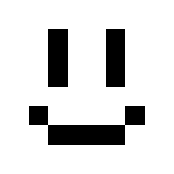

In [314]:
def draw_qr_code(array: np.ndarray, pixel_size: int = 2):
    """
    Cette fonction dessine un tableau 2D de booléens
    :param array: np.ndarray, le tableau 2D de booléens
    :param pixel_size: int, la taille d'un pixel
    """
    array = np.logical_not(array)
    plt.figure(figsize=(array.shape[1]*pixel_size/array.shape[0], pixel_size))
    plt.imshow(array, cmap='gray')
    plt.axis('off')
    plt.show()

array = [
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
]

array = np.array(array, dtype=bool)
draw_qr_code(array)

### Structure d'un QR code

Les QR codes ont une structure bien précise, avec des zones de calibrage, des zones de format, des zones de timing, des zones de données, des zones de correction d'erreur, etc.

![QR code](qr-code-structure.png)

Ici, nous allons seulement nous intéresser aux zones de données et de correction d'erreur. (version 1 21x21)

![QR code](qr-code-pattern.png)

Et pour simplifier on va suivre une structure bien plus simple, avec seulement des blocs de 2x4 bits.

x_array: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
y_array: [12, 0, 72, 101, 108, 108, 111, 32, 87, 111, 114, 108, 100, 33, 235, 111, 96, 133]


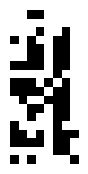

In [315]:
def encode_message(message: str, t: int) -> np.ndarray:
    """
    This function encodes a message by adding redundancy and converting it to a 2D array of booleans.
    :param message: str, the message to encode
    :param t: int, the number of errors we want to be able to correct
    :return: np.ndarray, the encoded message as a 2D array
    """
    # Encode the message length and message in ASCII
    message_length = len(message)
    length_encoded = message_length.to_bytes(2, byteorder='little')
    message_encoded = message.encode('ascii')
    
    # Combine the length and message
    combined_message = length_encoded + message_encoded
    
    # Convert the combined message to a numpy array of uint8
    message_array = np.frombuffer(combined_message, dtype=np.uint8)
    
    # Assume encode_message_rs is defined elsewhere and returns two arrays
    x_array, y_array = encode_message_rs(message_array.tolist(), t)
    print("x_array:", x_array)
    print("y_array:", y_array)
    
    # Create a 2D boolean array initialized to zeros
    array = np.zeros((len(y_array), 8), dtype=bool)
    
    # Populate the 2D array with bits from the x_array
    for i in range(len(y_array)):
        for j in range(8):
            array[i][j] = (y_array[i] >> j) & 1
    
    return array, y_array

# Example usage
encoded_message, original_y_array = encode_message("Hello World!", 4)
draw_qr_code(encoded_message)

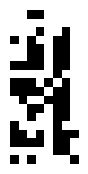

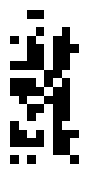

In [316]:
# Ajoute des erreurs random dans le message
def add_errors(array: np.ndarray, t: int) -> np.ndarray:
    """
    Cette fonction ajoute des erreurs aléatoires dans le message
    :param array: np.ndarray, le message à encoder
    :param t: int, le nombre d'erreurs à ajouter
    :return: np.ndarray, le message avec des erreurs
    """
    # Copy the array to avoid modifying the original
    array = array.copy()
    
    # Generate random indices for errors
    indices = np.random.choice(array.size, t, replace=False)
    
    # Add errors
    for index in indices:
        array[index // 8][index % 8] ^= 1
    
    return array

corrupted_message = add_errors(encoded_message, 2)
draw_qr_code(encoded_message)
draw_qr_code(corrupted_message)

In [317]:
def decode_message(encoded_array: np.ndarray, t: int) -> str:
    """
    This function decodes a message from a 2D array of booleans, correcting errors.
    :param encoded_array: np.ndarray, the encoded message as a 2D array of booleans
    :param t: int, the number of errors we want to be able to correct
    :return: str, the decoded message
    """
    # Convert the 2D boolean array back to a 1D array of bytes
    y_array = []
    for row in encoded_array:
        byte = 0
        for j in range(8):
            if row[j]:
                byte |= (1 << j)
        y_array.append(byte)

    # Make the x_array
    x_array = []
    for i in range(len(y_array)):
        x_array.append(i+1)
    print("x_array:", x_array)

    print("y_array:", y_array)

    # Assume localiser_erreurs_rs and corriger_erreurs_rs are defined elsewhere
    erreurs = localiser_erreurs_rs(y_array, t)
    print("erreurs:", erreurs)
    y_array = corriger_erreurs_rs(x_array, y_array, y_array, erreurs)
    print("y_array corrigé:", y_array)
    print("y_array original:", original_y_array)

    # Convert the corrected y_array to a bytes object
    corrected_message = bytes(y_array)

    # Decode the message
    message_length = int.from_bytes(corrected_message[:2], byteorder='big')
    message = corrected_message[2:2+message_length].decode('ascii')
    return message

message = decode_message(corrupted_message, 2)
print(message)

x_array: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
y_array: [12, 0, 72, 101, 236, 108, 111, 48, 87, 111, 114, 108, 100, 33, 235, 111, 96, 133]
erreurs: []


TypeError: corriger_erreurs_rs() takes 3 positional arguments but 4 were given